In [1]:
library(cowplot)
library(magrittr)
library(ggrepel)
library(igraph)
library(tidyverse)
library(tidygraph)
library(ggnetwork)
suppressWarnings(suppressMessages(library(network)))
suppressWarnings(suppressMessages(library(sna)))
library(RCy3)

theme_set(theme_cowplot())

# NDEx parameters
ndex_publish <- FALSE
ndex_pw <- NULL

results <- '../results/'
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(betweenness = centrality_betweenness(normalized = TRUE),
           degree = centrality_degree()) %>%
    left_join(vegas, by = c('name' = 'Gene'))
ppi_df <- as_tibble(ppi)

methods <- c('dmGWAS','heinz','HotNet2','LEAN','SConES GS','SConES GM','SConES GI','SigMod')

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA) # get rid of legend panel bg
)

Warning message:
“package ‘cowplot’ was built under R version 4.0.3”
Warning message:
“package ‘magrittr’ was built under R version 4.0.3”
Warning message:
“package ‘ggrepel’ was built under R version 4.0.3”
Loading required package: ggplot2

Warning message:
“package ‘ggplot2’ was built under R version 4.0.3”
Warning message:
“package ‘igraph’ was built under R version 4.0.3”

Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching packages ─────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

Warning message:
“package ‘tibble’ was built under R version 4.0.3”
Warning message:
“package ‘readr’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────────────── tidyverse_conflicts() ─

In [2]:
# from DisGeNET
known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene

g_known <- activate(ppi, nodes) %>%
    filter(name %in% known_brca_genes) %>%
    mutate(disgenet = TRUE)
class(g_known) <- c('igraph','tbl_graph')

# from BCAC
bcac_genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                       col_types = 'iciddddddcd') %>%
    filter(`Top-0.1-pvalue` < 0.05 / n()) %>%
    .$Gene

g_bcac <- activate(ppi, nodes) %>%
    filter(name %in% bcac_genes) %>%
    mutate(bcac = TRUE)
class(g_bcac) <- c('igraph','tbl_graph')

# Subnetworks

## LEAN

In [3]:
lean_p <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd')
lean <- lean_p$Gene[lean_p$PLEAN < 0.05]
g_lean <- activate(ppi, nodes) %>%
    filter(name %in% lean)

# do not upload to NDEx

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


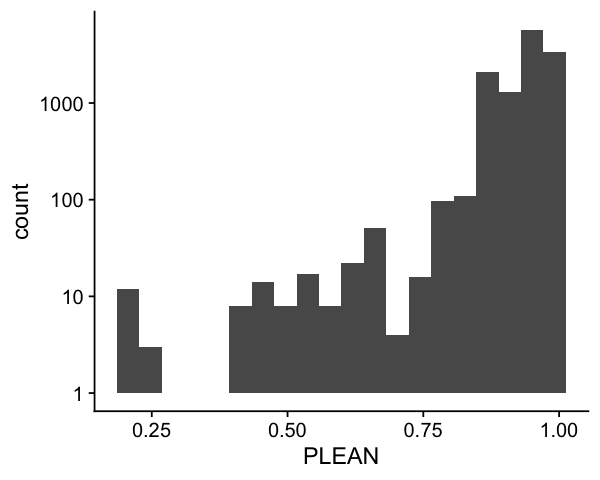

In [4]:
options(repr.plot.width=5, repr.plot.height=4)
ggplot(lean_p, aes(PLEAN)) +
    geom_histogram(bins = 20) +
    scale_y_log10()

## HotNet2

In [5]:
hotnet2_full <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')
hotnet2 <- hotnet2_full$gene
g_hotnet2 <- activate(ppi, nodes) %>%
    filter(name %in% hotnet2) %>%
    mutate(hotnet2 = TRUE)
class(g_hotnet2) <- c('igraph','tbl_graph')

# upload to NDEx
if(!is.null(ndex_pw)) {
    createNetworkFromIgraph(g_hotnet2, 
                            title = 'HotNet2', 
                            collection = 'GENESIS subnetworks')
    exportNetworkToNDEx('hclimente', ndex_pw,
                        isPublic=ndex_publish)
}

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


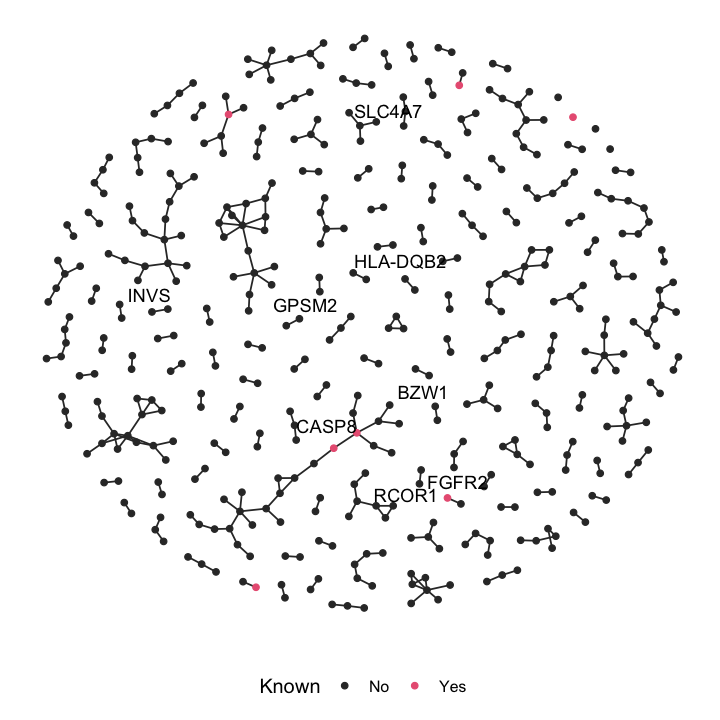

In [6]:
options(repr.plot.width=6, repr.plot.height=6)
g_hotnet2 %>%
    ggnetwork %>%
    mutate(name = as.character(name),
           disgenet = ifelse(name %in% known_brca_genes, 'Yes', 'No')) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(color = disgenet)) +
        geom_nodetext_repel(aes(label = ifelse(p < 0.001, name, '')),
                            nudge_x = -.05, nudge_y = -.05) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(color = 'Known') +
        scale_color_manual(values = c('No' = 'gray20', 'Yes' = '#e96182'))

In [7]:
options(repr.plot.width=6, repr.plot.height=4)
hotnet2_full %>%
    group_by(cluster) %>%
    summarize(size = n()) %>%
    group_by(size) %>%
    summarize(n = n(), clusters = paste(cluster, collapse = ','))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



size,n,clusters
<int>,<int>,<chr>
2,78,"101,103,104,105,106,107,108,113,114,115,116,117,118,119,12,121,122,123,124,125,126,128,129,130,131,132,133,134,135,15,18,20,26,29,30,31,32,33,34,38,39,40,41,43,45,50,53,54,55,56,57,59,6,60,62,65,67,71,74,77,79,8,80,81,84,85,86,88,89,90,92,93,94,95,96,97,98,99"
3,23,"100,102,110,111,112,120,127,14,16,2,22,23,27,3,42,44,47,52,68,73,78,82,83"
4,14,"1,10,109,21,24,37,46,48,51,58,66,75,9,91"
5,6,"13,49,61,69,70,76"
6,4,"5,7,72,87"
7,2,"25,36"
9,3,"4,63,64"
11,2,"11,19"
12,1,17


In [8]:
filter(hotnet2_full, gene %in% known_brca_genes & cluster == 35)

gene,cluster
<chr>,<chr>
BLM,35
CASP8,35


## Sigmod

In [9]:
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
g_sigmod <- activate(ppi, nodes) %>%
    filter(name %in% sigmod) %>%
    mutate(sigmod = TRUE)
class(g_sigmod) <- c('igraph','tbl_graph')

# upload to NDEx
if(!is.null(ndex_pw)) {
    createNetworkFromIgraph(g_sigmod, 
                            title = 'SigMod', 
                            collection = 'GENESIS subnetworks')
    exportNetworkToNDEx('hclimente', ndex_pw,
                        isPublic=ndex_publish)
}

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


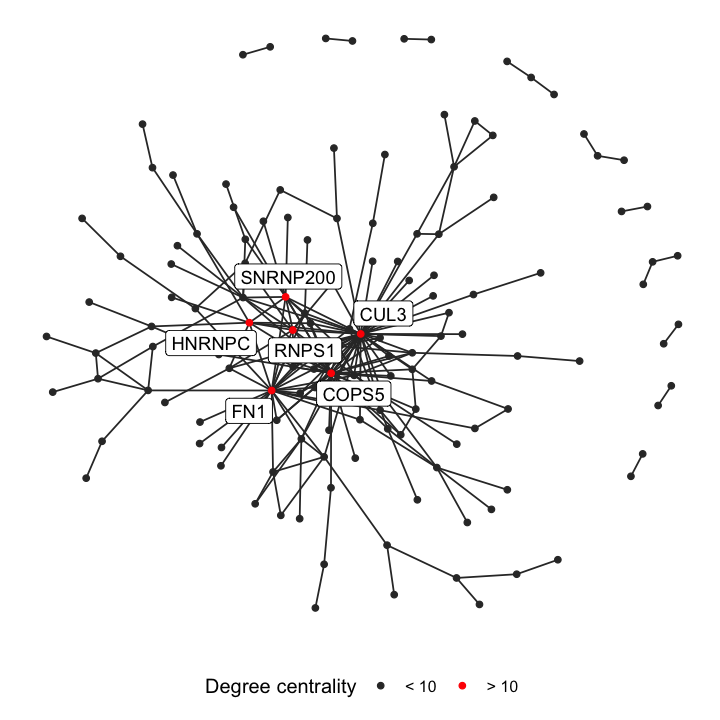

In [10]:
plt_df <- g_sigmod %>%
    mutate(d = centrality_degree()) %>%
    ggnetwork %>%
    mutate(name = as.character(name))

options(repr.plot.width=6, repr.plot.height=6)
ggplot() +
    geom_edges(data = plt_df, aes(x = x, y = y, xend = xend, yend = yend), color = 'gray20') +
    geom_nodes(data = plt_df, aes(x = x, y = y, color = ifelse(d > 10, '> 10', '< 10'))) +
    geom_label_repel(data = filter(plt_df, d > 10 & x == xend & y == yend) %>% select(x, y, name) %>% unique,
                     aes(x = x, y = y, label = name)) +
    theme_blank() +
    theme(legend.position = 'bottom') +
    labs(color = 'Degree centrality', size = bquote('-log' [10] ~'(P-value)')) +
    scale_color_manual(values = c('< 10' = 'gray20', '> 10' = 'red'))

## dmGWAS

In [11]:
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene

In [12]:
g_dmgwas <- activate(ppi, nodes) %>%
    filter(name %in% dmgwas) %>%
    mutate(dmgwas = TRUE)
class(g_dmgwas) <- c('igraph','tbl_graph')

# upload to NDEx
if(!is.null(ndex_pw)) {
    createNetworkFromIgraph(g_dmgwas, 
                            title = 'dmGWAS', 
                            collection = 'GENESIS subnetworks')
    exportNetworkToNDEx('hclimente', ndex_pw,
                        isPublic=ndex_publish)
}

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


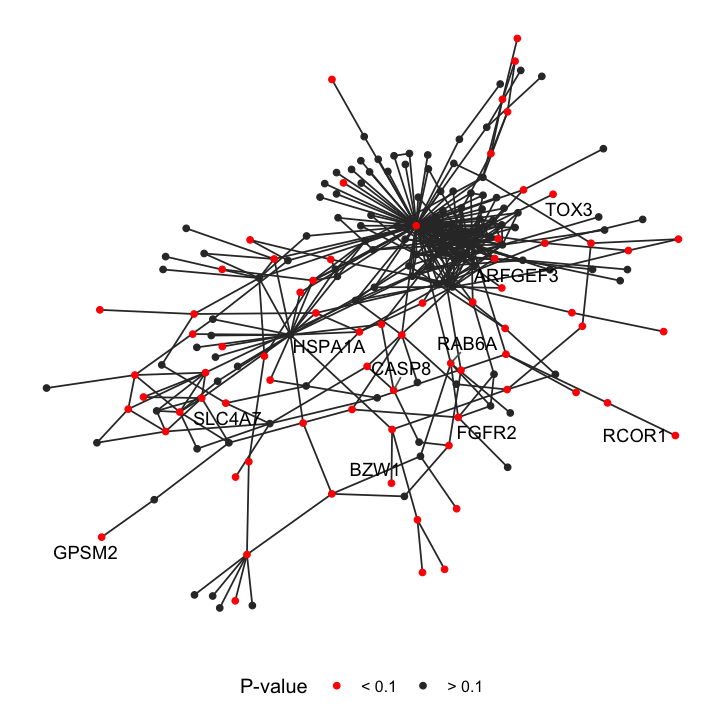

In [13]:
options(repr.plot.width=6, repr.plot.height=6)
g_dmgwas %>%
    ggnetwork %>%
    mutate(name = as.character(name)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(color = ifelse(p > 0.1, '> 0.1', '< 0.1'))) +
        geom_nodetext_repel(aes(label = ifelse(p < 0.001, name, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(color = 'P-value', size = bquote('-log' [10] ~'(P-value)')) +
        scale_color_manual(values = c('> 0.1' = 'gray20', '< 0.1' = 'red'))

## Heinz

In [14]:
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene

In [15]:
g_heinz <- activate(ppi, nodes) %>%
    filter(name %in% heinz) %>%
    mutate(heinz = TRUE)
class(g_heinz) <- c('igraph','tbl_graph')

# upload to NDEx
if(!is.null(ndex_pw)) {
    createNetworkFromIgraph(g_heinz, 
                            title = 'heinz', 
                            collection = 'GENESIS subnetworks')
    exportNetworkToNDEx('hclimente', ndex_pw,
                        isPublic=ndex_publish)
}

## SConES

In [16]:
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')

scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique
scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique
scones_gm
scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique

g_scones_gs <- activate(ppi, nodes) %>%
    filter(name %in% scones_gs) %>%
    mutate(scones_gs = TRUE)
class(g_scones_gs) <- c('igraph','tbl_graph')

g_scones_gm <- activate(ppi, nodes) %>%
    filter(name %in% scones_gm) %>%
    mutate(scones_gm = TRUE)
class(g_scones_gm) <- c('igraph','tbl_graph')

g_scones_gi <- activate(ppi, nodes) %>%
    filter(name %in% scones_gi) %>%
    mutate(scones_gi = TRUE)
class(g_scones_gi) <- c('igraph','tbl_graph')

# do not upload to NDEx

[1] "NEK10"          "MICOS10P3"      "RNU6-342P"      "SLC4A7"        
 [5] "RPS20P15"       "RNU1-96P"       "FGF10"          "FGF10-AS1"     
 [9] "LINC02224"      "RN7SL383P"      "MRPS30-DT"      "MRPS30"        
[13] "RNU6-271P"      "ZNF518A"        "NPM1P25"        "BLNK"          
[17] "OPALIN"         "DNTT"           "TLL2"           "TM9SF3"        
[21] "RNA5SP324"      "RPS2P36"        "PIK3AP1"        "RNU6-1274P"    
[25] "RPL13AP5"       "MIR607"         "LCOR"           "HMGN2P35"      
[29] "SLIT1"          "SLIT1-AS1"      "ARHGAP19-SLIT1" "ARHGAP19"      
[33] "RPL12P27"       "FRAT1"          "FRAT2"          "RRP12"         
[37] "RPL34P20"       "PGAM1"          "EXOSC1"         "ZDHHC16"       
[41] "MMS19"          "UBTD1"          "ANKRD2"         "HOGA1"         
[45] "C10orf62"       "MORN4"          "PI4K2A"         "AVPI1"         
[49] "MARVELD1"       "ZFYVE27"        "SFRP5"          "LINC00866"     
[53] "GOLGA7B"        "CRTAC1"         "RN7SKP167"      "FGFR2"         
[57] "TOX3"           "CASC16"

## Stability consensus

In [17]:
stab_consensus <- read_tsv(paste0(results,'benchmark/selected_genes.stability.txt'), col_types = 'c')$gene

In [18]:
g_stab_consensus <- activate(ppi, nodes) %>%
    filter(name %in% stab_consensus) %>%
    mutate(heinz = TRUE)
class(g_stab_consensus) <- c('igraph','tbl_graph')

# upload to NDEx
if(!is.null(ndex_pw)) {
    createNetworkFromIgraph(g_stab_consensus, 
                            title = 'Stable consensus', 
                            collection = 'GENESIS subnetworks')
    exportNetworkToNDEx('hclimente', ndex_pw,
                        isPublic=ndex_publish)
}

# Consensus subnetwork

Let's study how many genes are shared between the different solutions.

In [19]:
tibble(gene = c(dmgwas, heinz, hotnet2, lean, sigmod, scones_gi)) %>%
    group_by(gene) %>%
    summarize(num_methods = n() %>% as.character) %>%
    full_join(vegas, by = c("gene" = 'Gene')) %>%
    mutate(num_methods = ifelse(is.na(num_methods), 0, num_methods)) %>%
    select(num_methods) %>%
    table

`summarise()` ungrouping output (override with `.groups` argument)



.
    0     1     2     3 
32099   575    73    20 

Warning message:
“`as.tibble()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


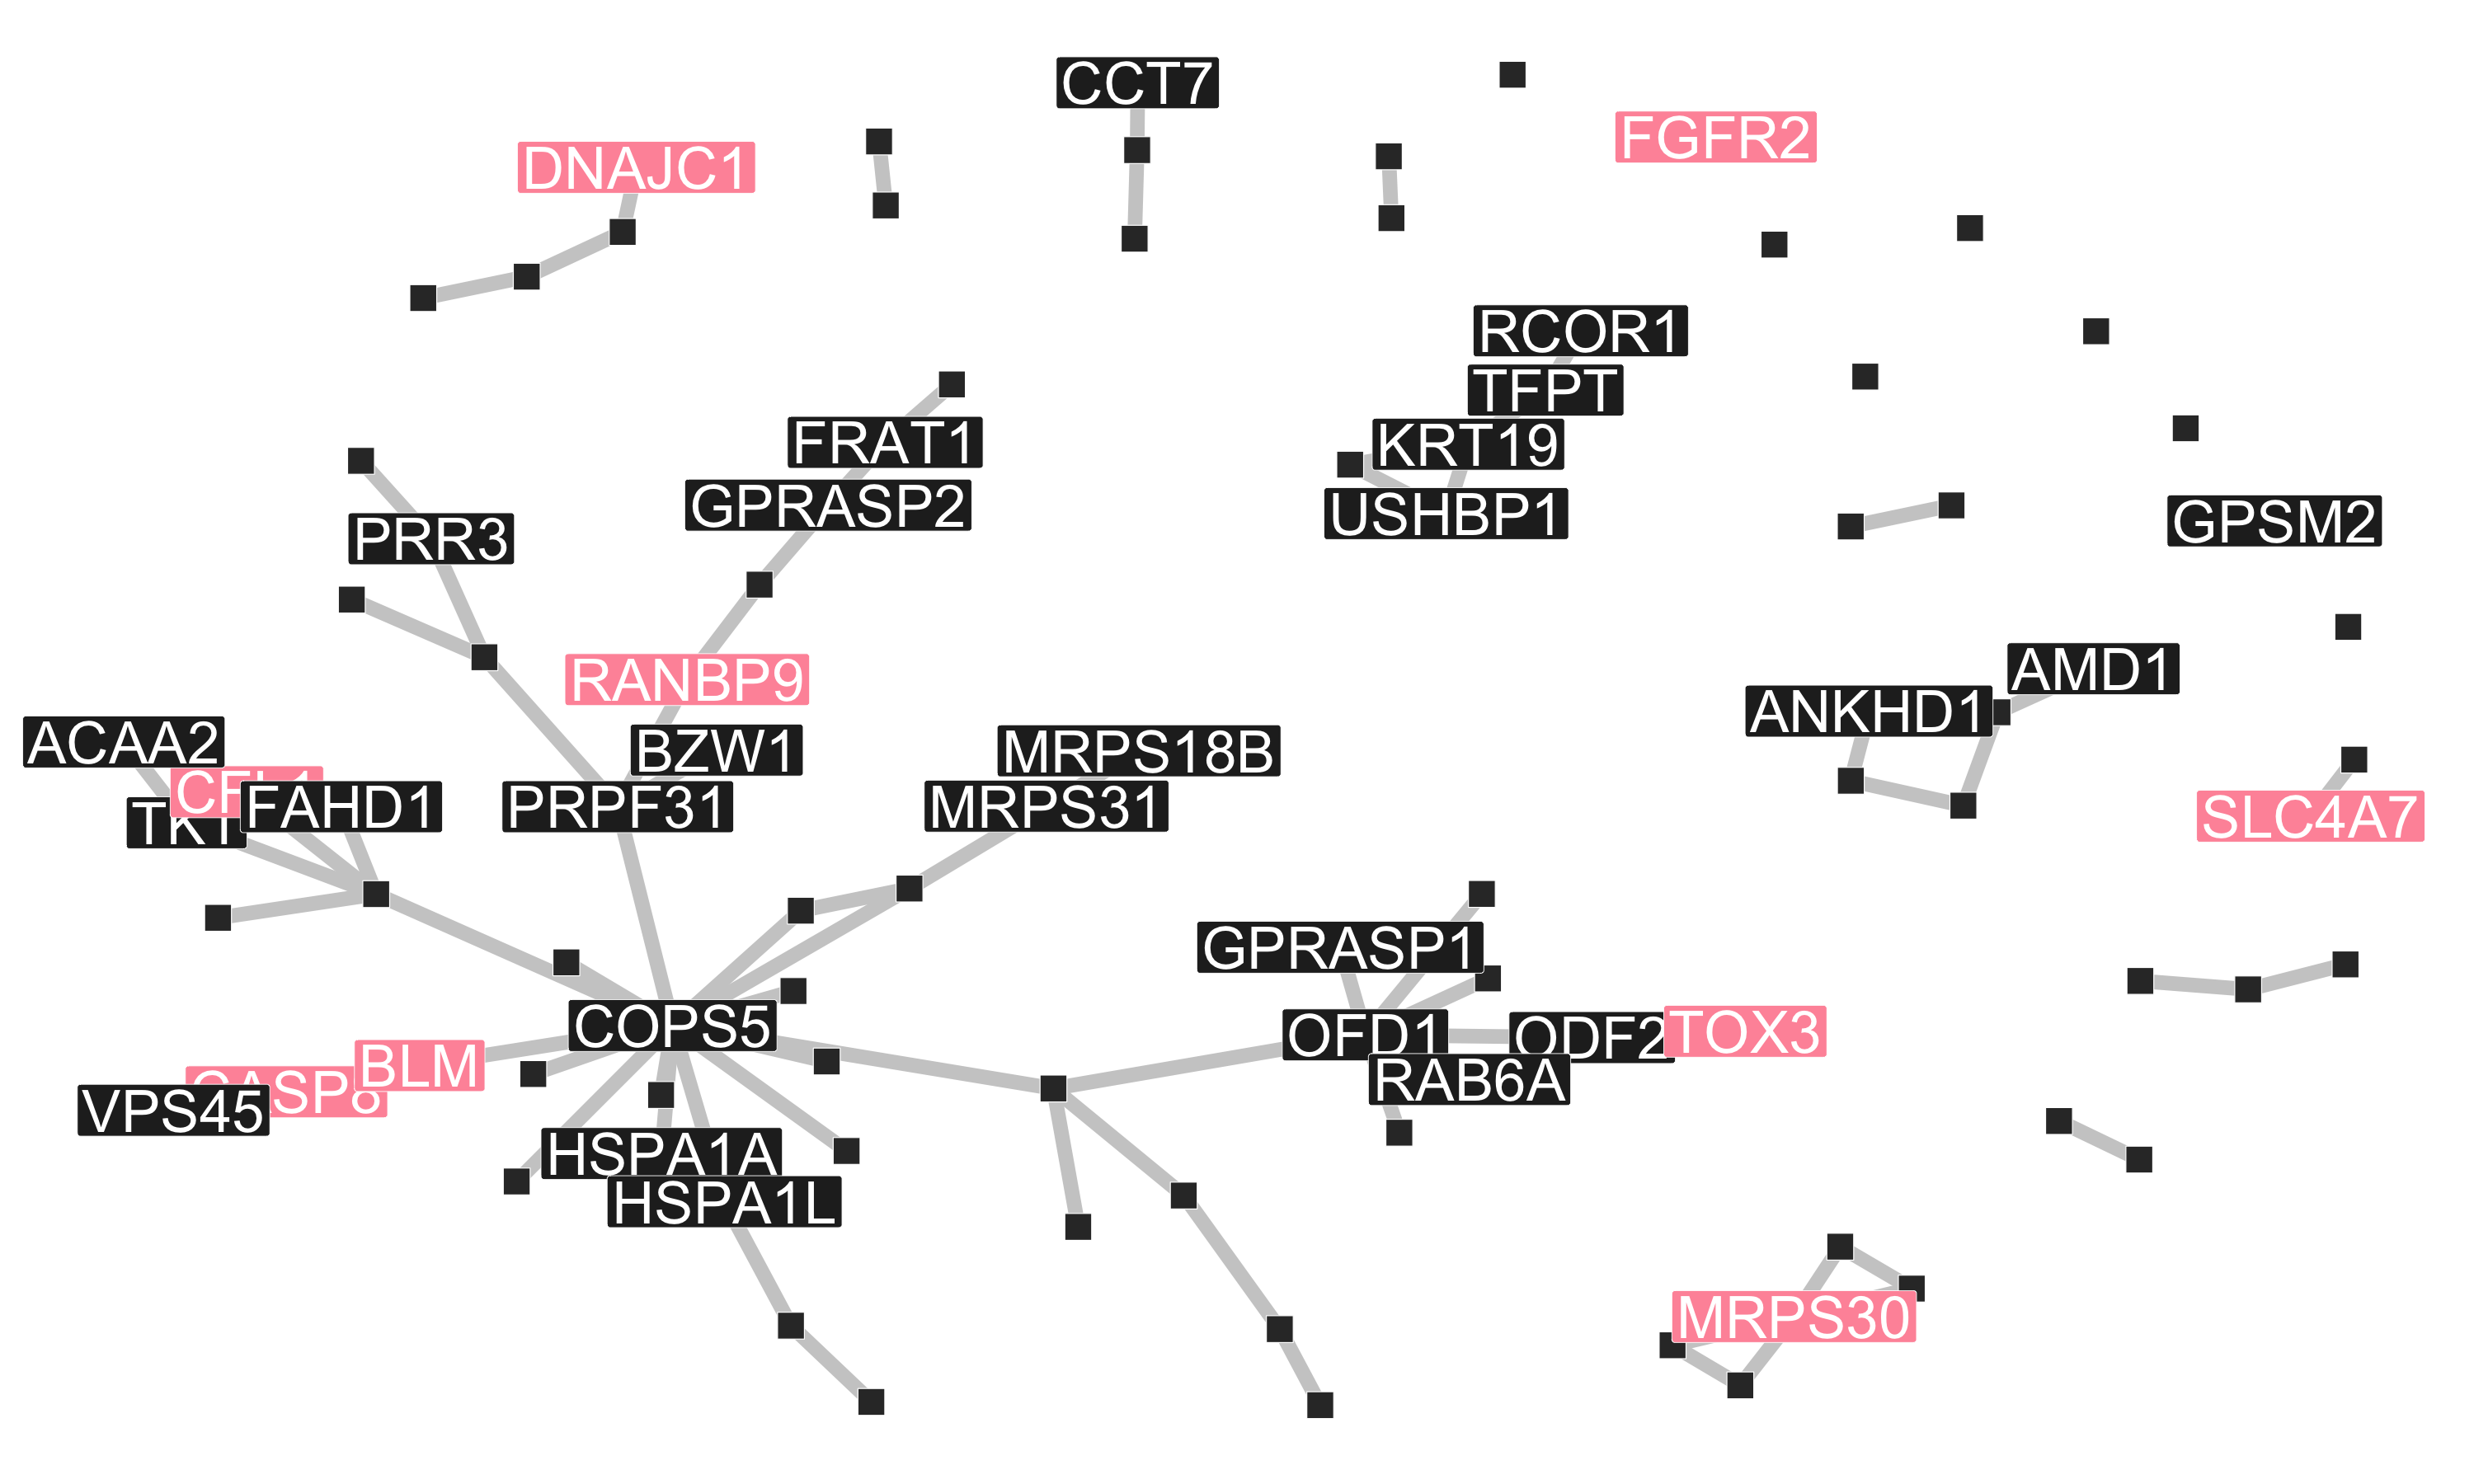

In [20]:
options(repr.plot.width=25, repr.plot.height=15)
consensus <- graph_join(g_sigmod, g_dmgwas, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_hotnet2, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_heinz, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_scones_gi, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_known, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_bcac, by = c('name','betweenness','degree','p')) %>%
    to_undirected %>%
    mutate(dmgwas = ifelse(is.na(dmgwas), FALSE, dmgwas),
           heinz = ifelse(is.na(heinz), FALSE, heinz),
           hotnet2 = ifelse(is.na(hotnet2), FALSE, hotnet2),
           scones_gi = ifelse(is.na(scones_gi), FALSE, scones_gi),
           sigmod = ifelse(is.na(sigmod), FALSE, sigmod),
           disgenet = ifelse(is.na(disgenet), FALSE, disgenet),
           bcac = ifelse(is.na(bcac), FALSE, bcac),
           num_methods = rowSums(cbind(dmgwas, heinz, hotnet2, sigmod, scones_gi))) %>%
    filter(num_methods > 1)

as.tibble(consensus) %>%
    rename(gene = name) %>%
    write_tsv(paste0(results,'consensus/consensus.tsv'))

consensus_gg <- consensus %>%
    ggnetwork

highlight <- consensus_gg$num_methods == 3 | 
             consensus_gg$p < 0.001 | 
             consensus_gg$degree > 100 |
             consensus_gg$bcac

ggplot() +
    geom_edges(data = consensus_gg, aes(x = x, y = y, xend = xend, yend = yend), 
               size = 5, color = 'grey80') +
    geom_nodes(data = filter(consensus_gg, !highlight), 
               aes(x = x, y = y), size = 10, fill = 'gray20', color = 'white', shape = 22) +
    geom_nodelabel(data = filter(consensus_gg, highlight), 
                   aes(x = x, y = y, label = name, fill = (bcac | disgenet)), 
                   size = 15, color = 'white') +
    theme_blank() +
    labs(size = '# methods') +
    scale_size_manual(values = c('2' = 6, '3' = 10)) +
    scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
    theme(text = element_text(size = 40), legend.position = 'none')

In [21]:
# upload to NDEx
if(!is.null(ndex_pw)) {
    createNetworkFromIgraph(consensus,
                            title = 'Consensus', 
                            collection = 'GENESIS subnetworks') %>%
        deleteDuplicateEdges
    exportNetworkToNDEx('hclimente', ndex_pw,
                        isPublic=ndex_publish)
    
    
}

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


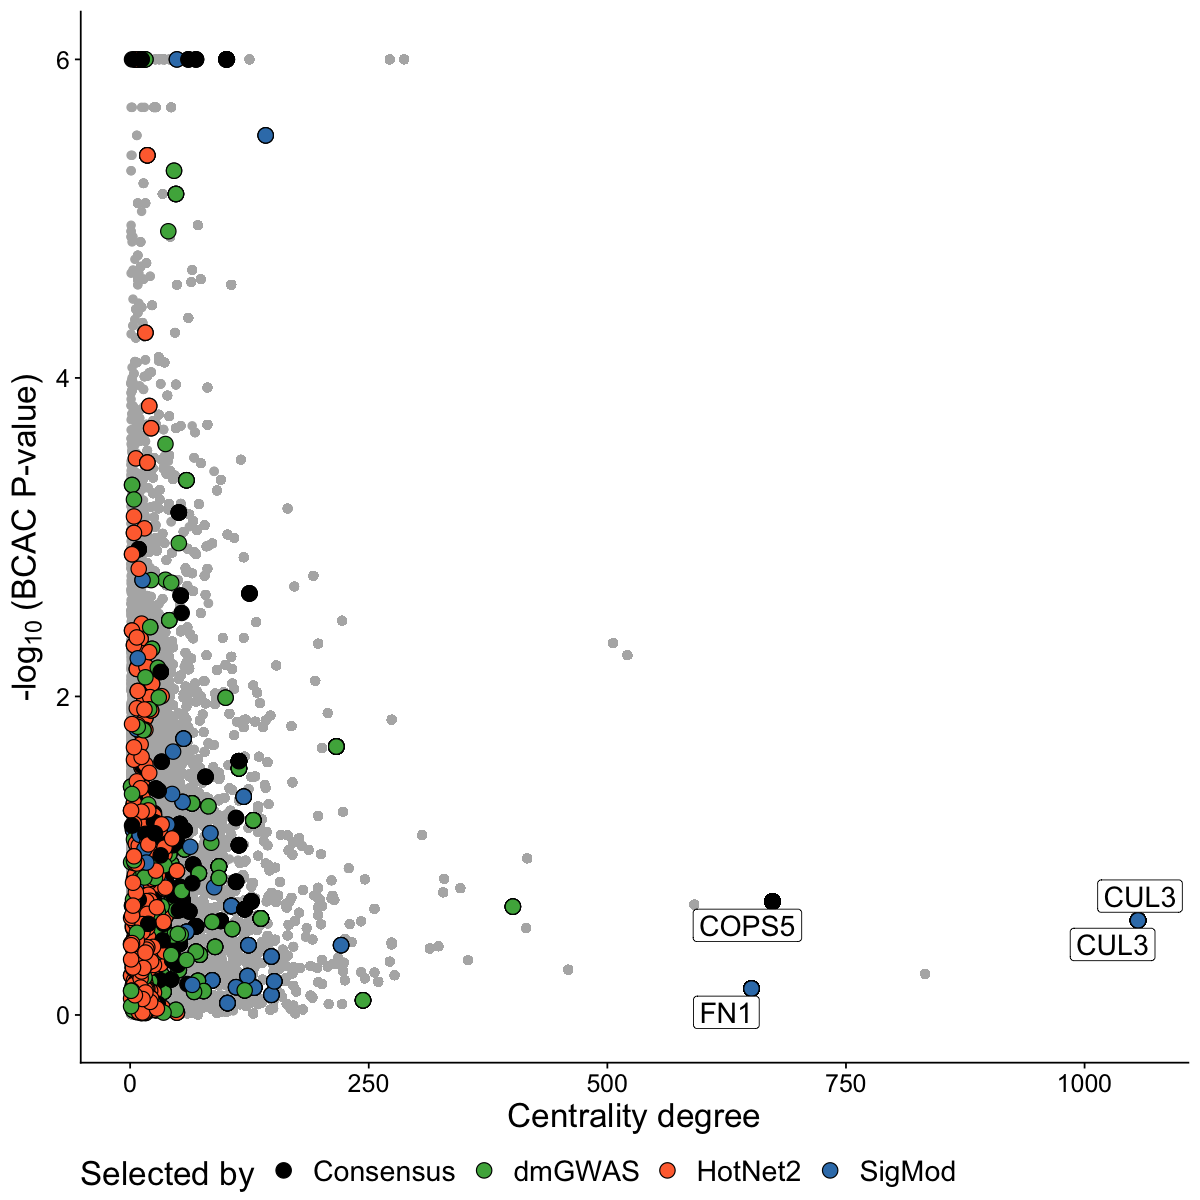

In [22]:
method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff6f3c', 'SConES GI' = '#cb181d',
                    'SigMod' = '#377eb8', 'All' = 'gray50', 
                    'Consensus' = 'black', 'GENESIS-significant' = '#000080',
                    'Conventional GWAS' = '#000080', 'Unselected' = 'gray70')

ppi_selection <- ppi %>%
    inner_join(read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd'), by = c('name' = 'Gene')) %>%
    mutate(p = Pvalue,
           what = ifelse(name %in% sigmod, 'SigMod', 'Unselected'),
           what = ifelse(name %in% dmgwas, 'dmGWAS', what),
           what = ifelse(name %in% hotnet2, 'HotNet2', what),
           what = ifelse(name %in% heinz, 'heinz', what),
           what = ifelse(name %in% scones_gi, 'SConES GI', what),
           what = ifelse(name %in% names(V(consensus)), 'Consensus', what))

options(repr.plot.width=10, repr.plot.height=10)
ggplot() +
    geom_point(data = ppi_selection, aes(x = degree, y = -log10(p)), color = 'gray70', size = 2) +
    geom_point(data = filter(ppi_selection, what != 'Unselected'),
               aes(x = degree, y = -log10(p), fill = what), size = 4, shape = 21) +
    geom_label_repel(data = filter(ppi_selection, what != 'Unselected' & degree > 500),
                     aes(x = degree, y = -log10(p), label = name), size = 6) +
    guides(size = FALSE) +
    labs(x = 'Centrality degree', y = bquote('-log' [10] ~'(BCAC P-value)'), fill = 'Selected by') +
    theme(legend.position = 'bottom', 
          text = element_text(size = 20),
          axis.text = element_text(size = 15)) +
    scale_fill_manual(values = method_palette)

# Heterogeneity study

Warning message:
“Removed 1 rows containing missing values (geom_text).”


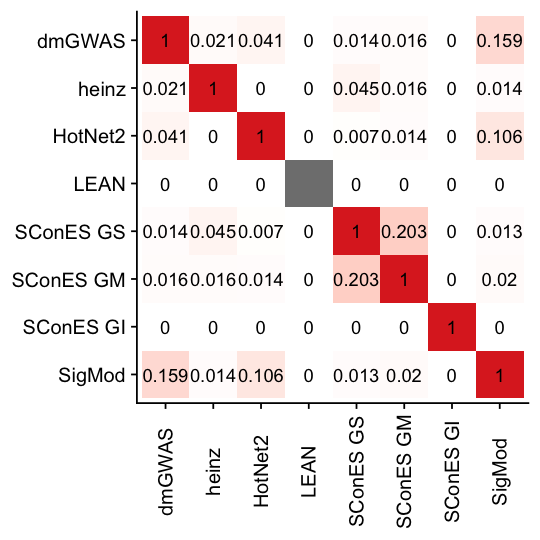

In [23]:
bms <- list(dmgwas, heinz, hotnet2, lean, scones_gs, scones_gm, scones_gi, sigmod)

options(repr.plot.width=4.5, repr.plot.height=4.5)
lapply(bms, function(x) 
       lapply(bms, function(x,y) 
           length(intersect(x,y))/length(union(x,y)), x) ) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, jaccard, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           jaccard = round(as.numeric(jaccard), digits = 3)) %>%
    ggplot(aes(x = method1, y = method2, fill = jaccard, label = jaccard)) +
        geom_tile() +
        geom_text() +
        scale_fill_gradient(low = 'white', high = '#de2d26') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(angle = 90, vjust = 0.5))

In [24]:
method_summary <- function(graph) {

    all_genes <- unique(vegas$Gene)
    consensus_nodes <- all_genes %in% names(V(consensus))
    method_nodes <- all_genes %in% names(V(graph))
    p <- cor(consensus_nodes, method_nodes)
    
    tibble(`# nodes` = length(V(graph)),
           `# edges` = length(E(graph)),
           `Median betweenness` = mean(as.tibble(graph) %>% 
                                       .$betweenness, na.rm = T) %>% 
                                       format(digits = 2, scientific = TRUE),
           `Median gene P-value` = median(as.tibble(graph) %>% .$p, na.rm = T) %>% format(digits = 2),
           `Pearson consensus` =  format(p, digits = 2),
           `Consensus overlap` =  intersect(names(V(consensus)), names(V(graph))) %>% length,
           Components = igraph::components(graph)$no %>% as.character )
    
}

In [25]:
methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod')

bind_rows(mutate(method_summary(ppi), Method = 'HINT'),
          mutate(method_summary(consensus), Method = 'Consensus'),
          mutate(method_summary(g_stab_consensus), Method = 'Stability consensus'),
          mutate(method_summary(g_dmgwas), Method = 'dmGWAS'),
          mutate(method_summary(g_heinz), Method = 'heinz'),
          mutate(method_summary(g_hotnet2), Method = 'HotNet2'),
          mutate(method_summary(g_lean), Method = 'LEAN'),
          mutate(method_summary(g_scones_gs), Method = 'SConES GS'),
          mutate(method_summary(g_scones_gm), Method = 'SConES GM'),
          mutate(method_summary(g_scones_gi), Method = 'SConES GI'),
          mutate(method_summary(g_sigmod), Method = 'SigMod')) %>%
    select(Method, everything())

Warning message in cor(consensus_nodes, method_nodes):
“the standard deviation is zero”
Warning message in cor(consensus_nodes, method_nodes):
“the standard deviation is zero”


Method,# nodes,# edges,Median betweenness,Median gene P-value,Pearson consensus,Consensus overlap,Components
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
HINT,13619,142541,1.8e-04,0.46,0.066,93,15
Consensus,93,186,5.5e-04,0.0063,1,93,21
Stability consensus,68,49,1e-03,0.0051,0.54,43,32
dmGWAS,194,450,5.3e-04,0.19,0.41,55,1
heinz,4,3,1.2e-03,0.0011,0.21,4,1
HotNet2,440,374,8.3e-05,0.047,0.31,63,130
LEAN,0,0,NaN,NA,NA,0,0
SConES GS,5,0,1.1e-04,2.6e-05,0.19,4,5
SConES GM,28,2,4.6e-05,0.066,0.12,6,27


# Consensus genes

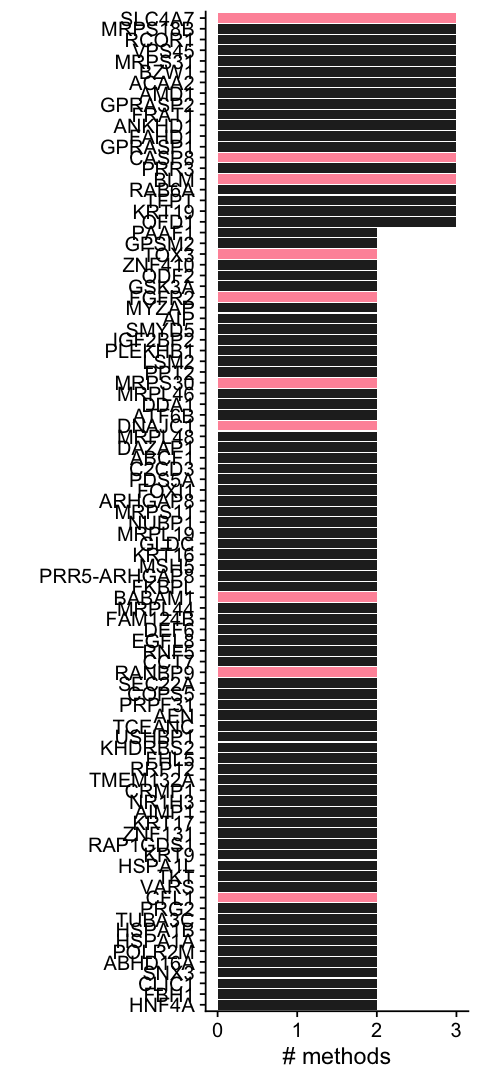

In [26]:
options(repr.plot.width=4, repr.plot.height=9)
as.tibble(consensus) %>%
    arrange(num_methods) %>%
    mutate(name = factor(name, levels = name)) %>%
    ggplot(aes(x = name, y = num_methods, fill = (disgenet | bcac ))) +
        geom_bar(stat = 'identity') +
        coord_flip() +
        scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
        labs(x = '', y = '# methods') +
        theme(legend.position = 'none')

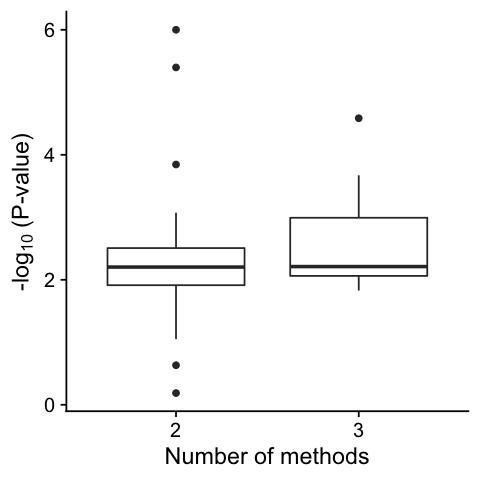

In [27]:
options(repr.plot.width=4, repr.plot.height=4)
as.tibble(consensus) %>%
    ggplot(aes(x = as.character(num_methods), y = -log10(p))) +
        geom_boxplot() +
        scale_color_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
        labs(x = 'Number of methods', y = bquote('-log'[10]~'(P-value)')) +
        theme(legend.position = 'bottom')

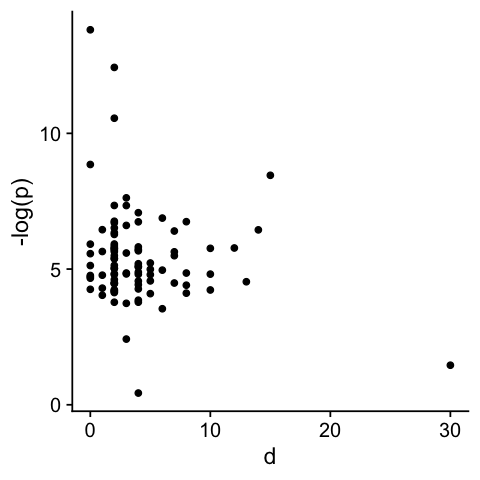

In [28]:
consensus %>%
    mutate(d = centrality_degree()) %>%
    as_tibble %>%
    ggplot(aes(x = d, y = -log(p))) +
        geom_point()

# Topology study

In [29]:
enrichment_test <- function(method, selected) {
    known_selected <- length(intersect(known_brca_genes, selected))
    known_not_selected <- length(setdiff(known_brca_genes, selected))
    unknown_selected <- length(intersect(vegas$Gene,selected)) - known_selected
    unknown_not_selected <- length(setdiff(vegas$Gene,selected)) - known_not_selected

    p <- fisher.test(matrix(c(known_selected,known_not_selected,
                              unknown_selected, unknown_not_selected),
                            nrow = 2), alternative = 'greater')$p.value %>% 
        format(digits = 2)
    
    tibble(method = method, p = p, 
           `BRCA selected`   = known_selected,
           `BRCA unselected` = known_not_selected,
           `Other selected`   = unknown_selected,
           `Other unselected`   = unknown_not_selected)
    
}

list(enrichment_test('dmGWAS', dmgwas), 
     enrichment_test('heinz', heinz),
     enrichment_test('HotNet2', hotnet2),
     enrichment_test('LEAN', lean),
     enrichment_test('SConES GS', scones_gs),
     enrichment_test('SConES GM', scones_gm),
     enrichment_test('SConES GI', scones_gi),
     enrichment_test('SigMod', sigmod),
     enrichment_test('Stability consensus', stab_consensus),
     enrichment_test('Consensus', names(V(consensus)))) %>%
    do.call(rbind,.)

method,p,BRCA selected,BRCA unselected,Other selected,Other unselected
<chr>,<chr>,<int>,<int>,<int>,<int>
dmGWAS,3.7e-05,7,146,187,32427
heinz,0.019,1,152,3,32611
HotNet2,0.0048,7,146,433,32181
LEAN,1,0,153,0,32614
SConES GS,0.0035,2,151,17,32597
SConES GM,0.03,2,151,56,32558
SConES GI,1,0,153,1,32613
SigMod,0.029,3,150,139,32475
Stability consensus,3e-04,4,149,64,32550


In [30]:
betweenness_test <- function(selected) {
    if (length(ppi_df$betweenness[ppi_df$name %in% selected])) {
        wilcox.test(ppi_df$betweenness[ppi_df$name %in% selected], 
                    ppi_df$betweenness[!ppi_df$name %in% selected])$p.value %>% 
        format(digits = 2)
    } else {
        NA
    }
}

list(tibble(method = 'dmGWAS', p = betweenness_test(dmgwas)),
     tibble(method = 'heinz', p = betweenness_test(heinz)),
     tibble(method = 'HotNet2', p = betweenness_test(hotnet2)),
     tibble(method = 'LEAN', p = betweenness_test(lean)),
     tibble(method = 'SConES GS', p = betweenness_test(scones_gs)),
     tibble(method = 'SConES GM', p = betweenness_test(scones_gm)),
     tibble(method = 'SConES GI', p = betweenness_test(scones_gi)),
     tibble(method = 'SigMod', p = betweenness_test(sigmod)),
     tibble(method = 'Stability consensus', p = betweenness_test(stab_consensus)),
     tibble(method = 'Consensus', p = betweenness_test(names(V(consensus))))) %>%
    do.call(rbind,.)

method,p
<chr>,<chr>
dmGWAS,1.4e-21
heinz,0.17
HotNet2,1.5e-08
LEAN,NA
SConES GS,0.37
SConES GM,0.27
SConES GI,NA
SigMod,2e-24
Stability consensus,1.1e-14


In [31]:
topology <- ppi %>%
    mutate(in_consensus = name %in% unique(consensus_gg[['name']]),
           what = ifelse(in_consensus, 'Consensus', 'Rest'),
           what = ifelse(name %in% known_brca_genes, 'Known', what),
           what = ifelse(in_consensus & name %in% known_brca_genes, 'Consensus + known', what)) %>%
    as.tibble %>%
    mutate(log_p = -log10(p),
           log_betweenness = log10(betweenness))

In [32]:
# centrality cancer-genes vs non-cancer-genes
wilcox.test(topology$betweenness[topology$name %in% known_brca_genes],
            topology$betweenness[!topology$name %in% known_brca_genes],
            alternative = 'greater')


	Wilcoxon rank sum test with continuity correction

data:  topology$betweenness[topology$name %in% known_brca_genes] and topology$betweenness[!topology$name %in% known_brca_genes]
W = 1064290, p-value = 2.636e-05
alternative hypothesis: true location shift is greater than 0


In [33]:
# centrality (cancer-genes + consensus) vs (cancer-genes + non-consensus)
wilcox.test(topology$betweenness[topology$in_consensus & topology$name %in% known_brca_genes],
            topology$betweenness[topology$in_consensus & ! (topology$name %in% known_brca_genes)])


	Wilcoxon rank sum test with continuity correction

data:  topology$betweenness[topology$in_consensus & topology$name %in% known_brca_genes] and topology$betweenness[topology$in_consensus & !(topology$name %in% known_brca_genes)]
W = 186, p-value = 0.5683
alternative hypothesis: true location shift is not equal to 0


In [34]:
# centrality (cancer-genes + consensus) vs (cancer-genes + non-consensus)
wilcox.test(topology$betweenness[topology$in_consensus],
            topology$betweenness[!topology$in_consensus])$p.value

[1] 4.288117e-18

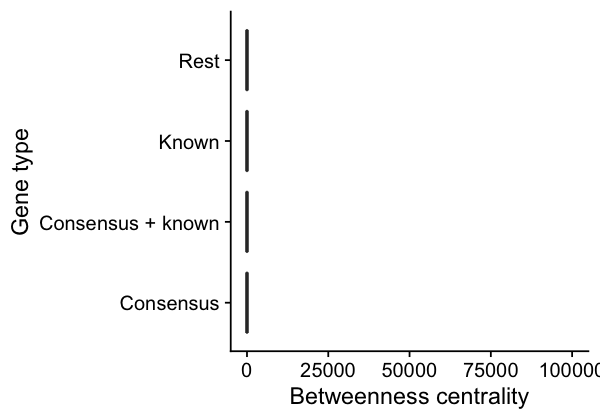

In [35]:
options(repr.plot.width=5, repr.plot.height=3.5)
topology %>%
    ggplot(aes(x = what, y = betweenness)) +
        geom_boxplot(outlier.colour = NA) +
        scale_y_continuous(limits = c(0, 1e+5)) +
        labs(x = 'Gene type', y = 'Betweenness centrality') +
        coord_flip()

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”


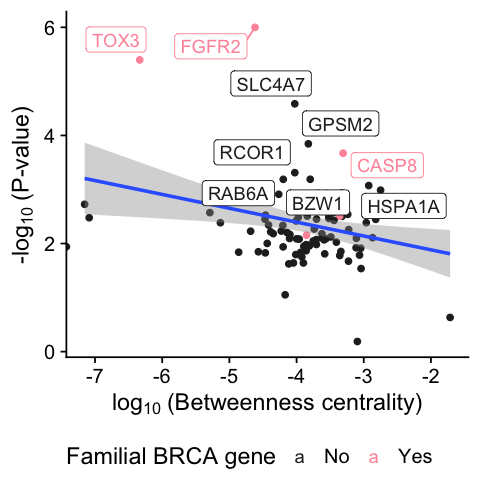

In [36]:
options(repr.plot.width=4, repr.plot.height=4)
filter(topology, grepl('Consensus', what)) %>%
    ggplot(aes(y = log_p, x = log_betweenness)) +
        geom_point(aes(color = ifelse(what == 'Consensus + known', 'Yes', 'No'))) +
        geom_smooth(method = "glm") +
        geom_label_repel(data = filter(topology, grepl('Consensus', what) & p < .001), 
                         aes(label = name, color = ifelse(what == 'Consensus + known', 'Yes', 'No'))) +
        labs(x = bquote('log'[10]~'(Betweenness centrality)'), 
             y = bquote('-log'[10]~'(P-value)'), color = 'Familial BRCA gene') +
        theme(legend.position = 'bottom') +
        scale_color_manual(values = c('Yes' = '#ff96a7', 'No' = '#252525'))

In [37]:
cor(topology$log_betweenness[grepl('Consensus', topology$what) & topology$betweenness != 0],
    topology$log_p[grepl('Consensus', topology$what) & topology$betweenness != 0])

[1] -0.2631677

[1] 49  5  5  5  4  3  3  2  2  2  2  2  1  1  1  1  1  1  1  1  1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



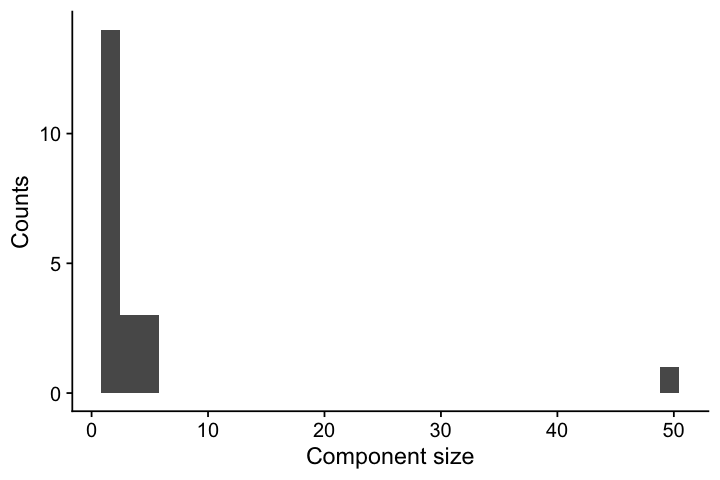

In [38]:
clusters <- clusters(consensus)

# get largest component
sort(clusters$csize, decreasing = TRUE)

options(repr.plot.width=6, repr.plot.height=4)
ggplot(tibble(size = clusters$csize), aes(size)) +
    geom_histogram() +
    labs(x = 'Component size', y = 'Counts')

In [39]:
median_p <- lapply(seq(clusters$no), function(i){
    mean(vegas$p[vegas$Gene %in% names(clusters$membership)[clusters$membership == i]])
}) %>%
    do.call(c,.)

tibble(size = clusters$csize, median_p = median_p) %>%
    mutate(num = 1:n())

size,median_p,num
<dbl>,<dbl>,<int>
49,2.492019e-02,1
1,2.689973e-03,2
4,9.594904e-03,3
5,8.343717e-03,4
5,3.075169e-02,5
1,9.429906e-03,6
2,1.050489e-02,7
3,4.786619e-03,8
3,2.449647e-03,9


In [40]:
list(tibble(gene = names(clusters$membership)[clusters$membership == 8],
            p = vegas$p[vegas$Gene %in% names(clusters$membership)[clusters$membership == 8]]),
     tibble(gene = names(clusters$membership)[clusters$membership == 7],
            p = vegas$p[vegas$Gene %in% names(clusters$membership)[clusters$membership == 7]]),
     tibble(gene = names(clusters$membership)[clusters$membership == 6],
            p = vegas$p[vegas$Gene %in% names(clusters$membership)[clusters$membership == 6]])) %>%
    do.call(rbind,.)

gene,p
<chr>,<dbl>
NR1H3,0.003439966
FKBPL,0.002679973
MSH5,0.008239918
ZNF131,0.014449856
FHL5,0.006559934
TUBA3C,0.009429906


In [41]:
as_tibble(consensus) %>%
    arrange(-betweenness) %>%
    head

name,betweenness,degree,p,sigmod,dmgwas,hotnet2,heinz,scones_gi,disgenet,bcac,num_methods
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>
COPS5,0.019286029,673,0.232767233,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,2
OFD1,0.004035115,252,0.001589984,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,3
HSPA1L,0.001780596,127,0.001029990,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,2
USHBP1,0.001505899,125,0.003569964,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,2
CRMP1,0.001382133,95,0.001658998,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,2
PRPF31,0.001353654,111,0.007799922,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,2


In [42]:
# COPS5 interrogation: neighbors in the consensus
filter(vegas, Gene %in% names(neighbors(consensus, 'COPS5'))) %>%
    filter(Gene != 'COPS5') %>%
    .$p %>%
    median

[1] 0.006589934

In [43]:
# COPS5 interrogation: neighbors in the PPIN and not in the consensus
filter(vegas, Gene %in% setdiff(names(neighbors(ppi, 'COPS5')), 
                                names(neighbors(consensus, 'COPS5')))) %>%
    filter(Gene != 'COPS5') %>%
    .$p %>%
    median

[1] 0.4340659

# Gene set enrichment analysis

## Consensus

In [44]:
dict <- read_tsv('../results/preprocessing/non_alt_loci_set.txt',
                          col_types = cols(.default = "c")) %>%
    select(symbol, entrez_id)

symbol2entrez <- dict$entrez_id
names(symbol2entrez) <- dict$symbol

entrez2symbol <- dict$symbol
names(entrez2symbol) <- dict$entrez_id

universe <- read_tsv('~/data/genesis/genesis_2019.bim', col_names = F, col_types = 'iciicc') %>%
    inner_join(read_tsv('../results/preprocessing/snp2hgnc.tsv', col_types = 'cc'), 
               by = c('X2' = 'snp')) %>%
    .$gene %>%
    symbol2entrez[.] %>%
    unique

Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”
Warning message in format_fortify(model = model, nodes = nodes, weights = "none", :
“duplicated edges detected”


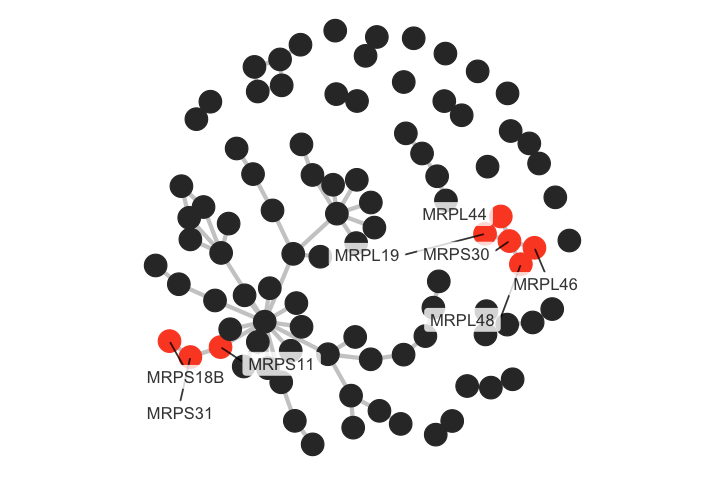

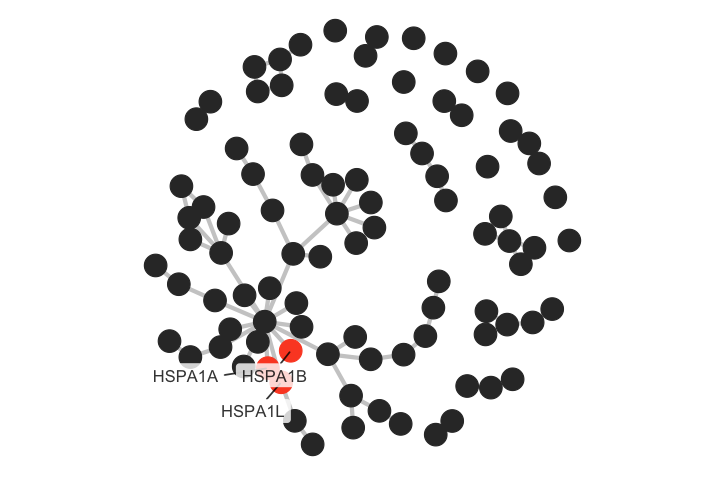

In [45]:
plot_pathway <- function(selected, filename) {
    
    set.seed(0)
    consensus_nodes <- read_tsv(paste0(results,'consensus/consensus.tsv'), 
                                col_types = 'cdidllllllli')

    consensus <- inner_join(ppi, consensus_nodes, by = c('name' = 'gene', 'p'))
    class(consensus) <- 'igraph'

    consensus <- consensus %>%
        ggnetwork %>%
        mutate(name = as.character(name))

    nodes <- mutate(consensus, 
                    highlighted = name %in% selected) %>%
        filter(xend == x & yend == y) %>% 
        select(x, y, name, highlighted) %>%
        unique
    edges <- filter(consensus, xend != x | yend != y)

    gg <- ggplot() +
        geom_edges(data = edges, aes(x = x, y = y, xend = xend, yend = yend), 
                   color = 'grey80', size = 1.2) +
        geom_nodes(data = nodes, aes(x = x, y = y, color = highlighted), size = 6) +
        geom_label_repel(data = filter(nodes, highlighted), 
                        aes(x = x, y = y, label = name), 
                        nudge_x = -.05, nudge_y = -.05, alpha = .8, label.size = NA,
                        hjust = 0.5, vjust = 0.5, size = 3.5) + 
        coord_fixed() +
        theme_blank() +
        labs(fill = 'Method') +
        scale_color_manual(values = c('TRUE' = '#fc4e2a', 'FALSE' = 'gray20')) +
        theme(legend.position = 'none') +
        theme_transparent
    ggsave(paste0('figs/', filename, '.pdf'), gg, width=5.1, height=5.1, bg = "transparent")
    gg
    
}

plot_pathway(c('MRPL44','MRPL19','MRPS11','MRPS31','MRPL48','MRPL46','MRPS30','MRPS18B'),
             'mitochondrial_translation')
plot_pathway(c('HSPA1A','HSPA1B','HSPA1L'),
             'attenuation_phase')

In [46]:
suppressPackageStartupMessages(library(ReactomePA))

enrichPathway(gene = symbol2entrez[names(clusters$membership)],
              universe = universe) %>%
    as_tibble %>%
    rowwise %>%
    mutate(geneID = strsplit(geneID, '/'),
           geneID = entrez2symbol[unlist(geneID)] %>% paste(collapse = '/'))

Loading required package: org.Hs.eg.db

Loading required package: AnnotationDbi

Warning message:
“package ‘AnnotationDbi’ was built under R version 4.0.3”
Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:statnet.common’:

    order


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, co

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-5368286,Mitochondrial translation initiation,8/64,84/10004,5.319589e-08,5.408249e-06,5.114271e-06,MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL46/MRPS30/MRPS18B,8
R-HSA-5389840,Mitochondrial translation elongation,8/64,84/10004,5.319589e-08,5.408249e-06,5.114271e-06,MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL46/MRPS30/MRPS18B,8
R-HSA-5419276,Mitochondrial translation termination,8/64,84/10004,5.319589e-08,5.408249e-06,5.114271e-06,MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL46/MRPS30/MRPS18B,8
R-HSA-5368287,Mitochondrial translation,8/64,90/10004,9.178985e-08,6.998976e-06,6.618531e-06,MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL46/MRPS30/MRPS18B,8
R-HSA-72766,Translation,9/64,260/10004,3.717595e-05,2.267733e-03,2.144465e-03,AIMP1/MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL46/MRPS30/MRPS18B,9
R-HSA-3371568,Attenuation phase,3/64,13/10004,6.823313e-05,3.468518e-03,3.279979e-03,HSPA1A/HSPA1B/HSPA1L,3
R-HSA-3371497,HSP90 chaperone cycle for steroid hormone receptors (SHR),4/64,50/10004,2.813474e-04,1.225871e-02,1.159236e-02,HSPA1A/HSPA1B/TUBA3C/HSPA1L,4
R-HSA-3371571,HSF1-dependent transactivation,3/64,23/10004,4.036470e-04,1.538904e-02,1.455254e-02,HSPA1A/HSPA1B/HSPA1L,3


In [47]:
# only major component
enrichPathway(gene = symbol2entrez[names(clusters$membership)[clusters$membership == 1]],
              universe = universe) %>%
    as_tibble %>%
    rowwise %>%
    mutate(geneID = strsplit(geneID, '/'),
           geneID = entrez2symbol[unlist(geneID)] %>% paste(collapse = '/'))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-3371568,Attenuation phase,3/37,13/10004,1.298567e-05,0.002506235,0.002105046,HSPA1A/HSPA1B/HSPA1L,3
R-HSA-3371571,HSF1-dependent transactivation,3/37,23/10004,7.838703e-05,0.007564349,0.006353475,HSPA1A/HSPA1B/HSPA1L,3


## HotNet2

In [48]:
enrichPathway(gene = symbol2entrez[hotnet2],
              universe = universe) %>%
    as_tibble %>%
    rowwise %>%
    mutate(geneID = strsplit(geneID, '/'),
           geneID = entrez2symbol[unlist(geneID)] %>% paste(collapse = '/'))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-5368286,Mitochondrial translation initiation,13/278,84/10004,4.772619e-07,0.0001140656,0.0001110262,MRPL16/MRPL17/MRPL19/MRPL44/MRPL46/MRPL48/MRPL51/MRPL57/MRPS30/MRPS11/MRPS18B/MRPS31/MRPS34,13
R-HSA-5389840,Mitochondrial translation elongation,13/278,84/10004,4.772619e-07,0.0001140656,0.0001110262,MRPL16/MRPL17/MRPL19/MRPL44/MRPL46/MRPL48/MRPL51/MRPL57/MRPS30/MRPS11/MRPS18B/MRPS31/MRPS34,13
R-HSA-5419276,Mitochondrial translation termination,13/278,84/10004,4.772619e-07,0.0001140656,0.0001110262,MRPL16/MRPL17/MRPL19/MRPL44/MRPL46/MRPL48/MRPL51/MRPL57/MRPS30/MRPS11/MRPS18B/MRPS31/MRPS34,13
R-HSA-5368287,Mitochondrial translation,13/278,90/10004,1.079773e-06,0.0001935494,0.0001883921,MRPL16/MRPL17/MRPL19/MRPL44/MRPL46/MRPL48/MRPL51/MRPL57/MRPS30/MRPS11/MRPS18B/MRPS31/MRPS34,13
R-HSA-8982491,Glycogen metabolism,6/278,25/10004,4.949505e-05,0.0070975902,0.0069084670,PHKA2/PHKB/GYG1/GYG2/GYS2/PPP1R3C,6
R-HSA-3229121,Glycogen storage diseases,4/278,14/10004,4.686928e-04,0.0432010345,0.0420498948,GYG1/GYG2/GYS2/PPP1R3C,4
R-HSA-3322077,Glycogen synthesis,4/278,14/10004,4.686928e-04,0.0432010345,0.0420498948,GYG1/GYG2/GYS2/PPP1R3C,4
R-HSA-383280,Nuclear Receptor transcription pathway,7/278,51/10004,4.820199e-04,0.0432010345,0.0420498948,HNF4A/NR1H3/PPARD/RARA/RXRG/NR2F6/NR5A2,7
R-HSA-70221,Glycogen breakdown (glycogenolysis),4/278,15/10004,6.252392e-04,0.0498107265,0.0484834643,PHKA2/PHKB/GYG1/GYG2,4


## SigMod

In [49]:
enrichPathway(gene = symbol2entrez[sigmod],
              universe = universe) %>%
    as_tibble %>%
    rowwise %>%
    mutate(geneID = strsplit(geneID, '/'),
           geneID = entrez2symbol[unlist(geneID)] %>% paste(collapse = '/'))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-5368286,Mitochondrial translation initiation,9/104,84/10004,1.926966e-07,2.768408e-05,2.603095e-05,MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL34/MRPL46/MRPS30/MRPS18B,9
R-HSA-5389840,Mitochondrial translation elongation,9/104,84/10004,1.926966e-07,2.768408e-05,2.603095e-05,MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL34/MRPL46/MRPS30/MRPS18B,9
R-HSA-5419276,Mitochondrial translation termination,9/104,84/10004,1.926966e-07,2.768408e-05,2.603095e-05,MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL34/MRPL46/MRPS30/MRPS18B,9
R-HSA-5368287,Mitochondrial translation,9/104,90/10004,3.511089e-07,3.783198e-05,3.557287e-05,MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL34/MRPL46/MRPS30/MRPS18B,9
R-HSA-72163,mRNA Splicing - Major Pathway,11/104,172/10004,1.575855e-06,1.358387e-04,1.277272e-04,SRSF2/SNRNP40/CDC40/SNRNP200/HNRNPC/GCFC2/SNU13/RNPS1/PRPF31/PRPF19/LSM2,11
R-HSA-72172,mRNA Splicing,11/104,180/10004,2.461739e-06,1.675275e-04,1.575237e-04,SRSF2/SNRNP40/CDC40/SNRNP200/HNRNPC/GCFC2/SNU13/RNPS1/PRPF31/PRPF19/LSM2,11
R-HSA-72766,Translation,13/104,260/10004,2.720864e-06,1.675275e-04,1.575237e-04,RPS9/RPS6/RPS15/AIMP1/MRPL44/MRPL19/MRPS11/MRPS31/MRPL48/MRPL34/MRPL46/MRPS30/MRPS18B,13
R-HSA-72203,Processing of Capped Intron-Containing Pre-mRNA,11/104,228/10004,2.344636e-05,1.263173e-03,1.187743e-03,SRSF2/SNRNP40/CDC40/SNRNP200/HNRNPC/GCFC2/SNU13/RNPS1/PRPF31/PRPF19/LSM2,11
R-HSA-6809371,Formation of the cornified envelope,8/104,124/10004,4.233633e-05,2.027440e-03,1.906373e-03,KRT14/KRT19/KRT13/KRT15/KRT9/KRT17/KRT36/KRT16,8


## dmGWAS

In [50]:
enrichPathway(gene = symbol2entrez[dmgwas],
              universe = universe) %>%
    as_tibble %>%
    rowwise %>%
    mutate(geneID = strsplit(geneID, '/'),
           geneID = entrez2symbol[unlist(geneID)] %>% paste(collapse = '/'))

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
R-HSA-5617833,Cilium Assembly,18/120,189/10004,8.448126e-12,4.899913e-09,4.179599e-09,OFD1/HAUS5/CEP152/FGFR1OP/CSNK1E/PCM1/ODF2/CEP162/HAUS3/DYNLL2/IFT57/C2CD3/NEDD1/IFT81/IFT74/BBS4/CEP89/SDCCAG8,18
R-HSA-5620912,Anchoring of the basal body to the plasma membrane,13/120,95/10004,8.397298e-11,2.435217e-08,2.077226e-08,OFD1/HAUS5/CEP152/FGFR1OP/CSNK1E/PCM1/ODF2/CEP162/HAUS3/C2CD3/NEDD1/CEP89/SDCCAG8,13
R-HSA-1852241,Organelle biogenesis and maintenance,18/120,279/10004,5.076175e-09,9.182449e-07,7.832579e-07,OFD1/HAUS5/CEP152/FGFR1OP/CSNK1E/PCM1/ODF2/CEP162/HAUS3/DYNLL2/IFT57/C2CD3/NEDD1/IFT81/IFT74/BBS4/CEP89/SDCCAG8,18
R-HSA-380259,Loss of Nlp from mitotic centrosomes,10/120,69/10004,7.915904e-09,9.182449e-07,7.832579e-07,OFD1/HAUS5/CEP152/FGFR1OP/CSNK1E/PCM1/ODF2/HAUS3/NEDD1/SDCCAG8,10
R-HSA-380284,Loss of proteins required for interphase microtubule organization from the centrosome,10/120,69/10004,7.915904e-09,9.182449e-07,7.832579e-07,OFD1/HAUS5/CEP152/FGFR1OP/CSNK1E/PCM1/ODF2/HAUS3/NEDD1/SDCCAG8,10
R-HSA-8854518,AURKA Activation by TPX2,10/120,72/10004,1.211189e-08,1.170816e-06,9.986998e-07,OFD1/HAUS5/CEP152/FGFR1OP/CSNK1E/PCM1/ODF2/HAUS3/NEDD1/SDCCAG8,10
R-HSA-380270,Recruitment of mitotic centrosome proteins and complexes,10/120,78/10004,2.675815e-08,1.939966e-06,1.654780e-06,OFD1/HAUS5/CEP152/FGFR1OP/CSNK1E/PCM1/ODF2/HAUS3/NEDD1/SDCCAG8,10
R-HSA-380287,Centrosome maturation,10/120,78/10004,2.675815e-08,1.939966e-06,1.654780e-06,OFD1/HAUS5/CEP152/FGFR1OP/CSNK1E/PCM1/ODF2/HAUS3/NEDD1/SDCCAG8,10
R-HSA-69278,"Cell Cycle, Mitotic",22/120,475/10004,3.896377e-08,2.510999e-06,2.141868e-06,PSMD14/OFD1/HAUS5/CEP152/FGFR1OP/CCNA2/CDK2/RRM2/CDKN2A/CSNK1E/RAB1A/RAE1/PCM1/ODF2/HAUS3/DYNLL2/CDC6/CENPE/SPC24/NEDD1/SPC25/SDCCAG8,22
